# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
#importing important libarary

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split

In [2]:
from sklearn import tree
from sklearn.calibration import CalibratedClassifierCV
import math
import graphviz 
from sklearn.tree import DecisionTreeClassifier

In [3]:
con = sqlite3.connect("database.sqlite")

In [4]:
amzn = pd.read_sql_query('''SELECT * 
                            FROM Reviews 
                            WHERE Score != 3 
                            ORDER BY Time''', con)

In [5]:
def partition(score):
    if score < 3:
        return 0
    else : 
        return 1
amzn_score = amzn["Score"] 
filter_amzn = amzn_score.map(partition)
amzn['Score'] = filter_amzn

In [6]:
#sorting data
sorted_data = amzn.sort_values("ProductId", axis = 0, ascending = True, \
                       inplace = False, na_position = 'last')

In [7]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [8]:
final['Score'].value_counts()

1    307063
0     57110
Name: Score, dtype: int64

In [9]:
final = final.iloc[0:100000]

In [10]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [11]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [12]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|█████████████████████████████████| 100000/100000 [03:39<00:00, 454.67it/s]


In [13]:
#splitting data into train and test
x_train = preprocessed_reviews[slice(0,70000)]
x_cv = preprocessed_reviews[slice(70000, 85000)]
x_test = preprocessed_reviews[slice(85000, 100000)]
y_train = final.iloc[:70000, 6]
y_cv = final.iloc[70000:85000, 6]
y_test = final.iloc[85000:100000, 6]

## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

In [14]:
# Please write all the code with proper documentation

100%|███████████████████████████████████████████| 6/6 [30:21<00:00, 418.44s/it]


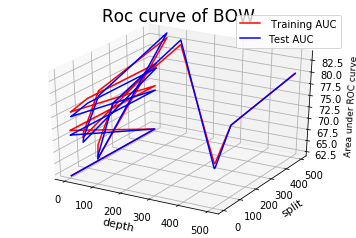

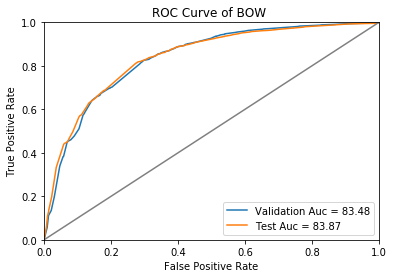

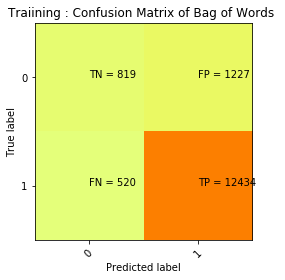

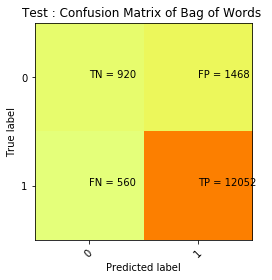

In [15]:
# Please write all the code with proper documentation
#defining function for Bag of words
def bow(para, bow_x_cv, bow_x_test):  
    count_vect = CountVectorizer() #in scikit-learn
    bow_x_train = count_vect.fit_transform(para)
    bow_x_cv = count_vect.transform(x_cv)
    bow_x_test = count_vect.transform(x_test)
    return bow_x_train, bow_x_cv, bow_x_test, count_vect



#vectorizing using above function
bow_x_train, bow_x_cv, bow_x_test, count_vect = bow(x_train, x_cv, x_test)



auc_cv = []
auc_test = []
depth = [1, 5, 10, 50, 100, 500]
split = [5, 10, 100, 500]
depth_x = []
split_y = []
for i in tqdm(depth):
    for j in split:
        bow_clf = DecisionTreeClassifier(max_depth = i , min_samples_split = j )
        

        # fitting the model on crossvalidation train
        bow_clf.fit(bow_x_train, y_train)

    
        y_pred_proba = bow_clf.predict_proba(bow_x_cv)[::,1]
        fpr, tpr, _ = metrics.roc_curve(y_cv,  y_pred_proba)
        auc_cv.append(np.round(metrics.roc_auc_score(y_cv, y_pred_proba)*100))
    
        y_pred_proba1 = bow_clf.predict_proba(bow_x_test)[::,1]
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba1)
        auc_test.append(np.round(metrics.roc_auc_score(y_test, y_pred_proba1)*100))
        
        depth_x.append(i)
        split_y.append(j)
        
        
        
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})

ax.set_xlabel("depth", fontsize=11)
ax.set_ylabel("split", fontsize=11)
ax.set_zlabel("Area under ROC curve   ", fontsize = 9, rotation=150)
ax.set_title("Roc curve of BOW", fontsize=17)

ax.plot(depth_x, split_y, auc_cv, color='red', label =" Training AUC")
ax.plot(depth_x, split_y, auc_test, color='blue', label = "Test AUC")    
ax.legend()
plt.show()      

        
        
        
        
index  = auc_cv.index(max(auc_cv))
i = index//4
j = index % 4
b_opt_depth = depth[i]
b_opt_split = split[j]





bow_clf = DecisionTreeClassifier(max_depth = b_opt_depth , min_samples_split = b_opt_split )
bow_clf.fit(bow_x_train, y_train)





#auc curve of optimal k on validation and test data
y_predk_proba = bow_clf.predict_proba(bow_x_cv)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_cv,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_cv, y_predk_proba)*100, 2)
b_tr_auc = auc

plt.plot(fpr,tpr,label="Validation Auc = "+str(auc))
y_predk_proba = bow_clf.predict_proba(bow_x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_test, y_predk_proba)*100, 2)
b_ts_auc = auc

plt.plot(fpr,tpr,label="Test Auc = "+str(auc))
plt.legend(loc=4)
plt.plot([x/10 for x in range(0, 11)],[x/10 for x in range(0, 11)], color='grey')
plt.title("ROC Curve of BOW ")
plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()



y_pred_test = bow_clf.predict(bow_x_test)
y_pred_cv = bow_clf.predict(bow_x_cv)



# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_cv,y_pred_cv)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title("Traiining : Confusion Matrix of Bag of Words ")
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()



# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_test,y_pred_test)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title("Test : Confusion Matrix of Bag of Words ")
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

In [16]:
# Please write all the code with proper documentation

In [17]:
bow_features_prob = bow_clf.feature_importances_

In [18]:
bow_pos_df = pd.DataFrame({'log prob': bow_features_prob,
                   'word': count_vect.get_feature_names()[:]
                  })
bow_pos_largest_10= bow_pos_df.nlargest(20, 'log prob')

In [19]:
from prettytable import PrettyTable
    
x = PrettyTable()
print("Top 20 features belonging BOW ")
x.field_names = ["Top ten fetures", "Features Log Probability", "Word"]
for i in range(0, 20):
    x.add_row([i+1, bow_pos_largest_10["log prob"].values[i] ,\
               bow_pos_largest_10["word"].values[i]])

print(x)

Top 20 features belonging BOW 
+-----------------+--------------------------+---------------+
| Top ten fetures | Features Log Probability |      Word     |
+-----------------+--------------------------+---------------+
|        1        |   0.09802022978590816    |      not      |
|        2        |   0.05232225096753439    |  disappointed |
|        3        |   0.05110816043589428    |     great     |
|        4        |   0.04029555307825786    |     money     |
|        5        |   0.03569221327610531    |      best     |
|        6        |   0.03543389072291528    |     worst     |
|        7        |   0.02467342259809081    |      love     |
|        8        |   0.023236434067811878   |     threw     |
|        9        |   0.02170696316124928    |   delicious   |
|        10       |   0.019336090522619427   |      good     |
|        11       |   0.018934285165864487   |    terrible   |
|        12       |   0.01812062735314726    |     waste     |
|        13       |   0.

### [5.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

In [20]:
# Please write all the code with proper documentation

In [21]:
dot_data = tree.export_graphviz(bow_clf, out_file=None, feature_names=count_vect.get_feature_names() ) 
graph = graphviz.Source(dot_data) 
graph.render("amzn_DT")

'amzn_DT.pdf'

In [22]:
class_name = np.array(['0', '1'])

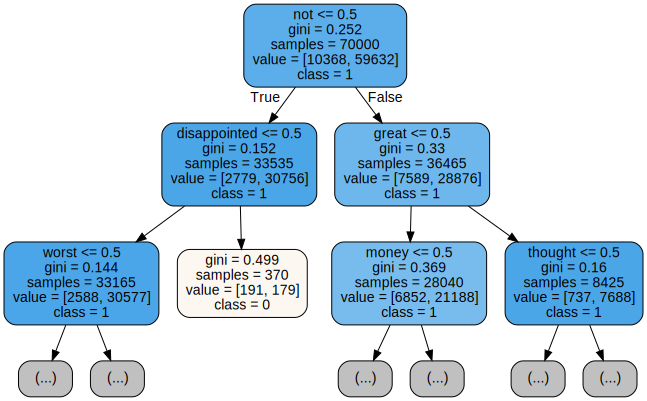

In [23]:
dot_data = tree.export_graphviz(bow_clf, out_file=None, 
                      feature_names=count_vect.get_feature_names(),
                      max_depth= 2,         
                      class_names = class_name,  
                      filled=True, rounded=True,  
                      special_characters=False)  
graph = graphviz.Source(dot_data)  
graph

## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

In [24]:
# Please write all the code with proper documentation

100%|███████████████████████████████████████████| 6/6 [38:14<00:00, 528.63s/it]


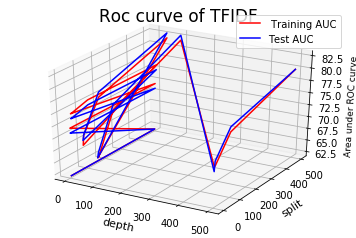

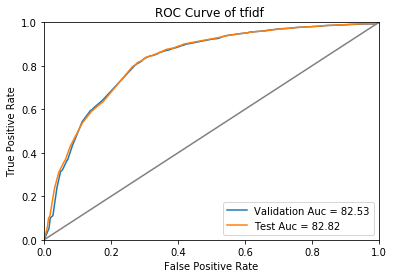

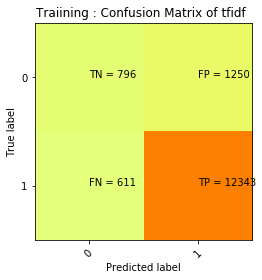

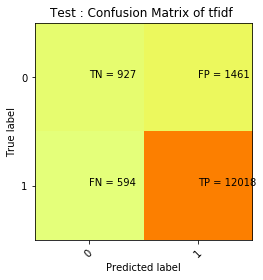

In [25]:
# Please write all the code with proper documentation
#defining function for Bag of words
def tfidf(preprocessed_reviews, x_cv, x_test):
    tf_idf_vect = TfidfVectorizer()
    vectorizer = tf_idf_vect.fit_transform(preprocessed_reviews)
    tfidf_x_cv = tf_idf_vect.transform(x_cv)
    tfidf_x_test = tf_idf_vect.transform(x_test)
    return vectorizer, tfidf_x_cv, tfidf_x_test, tf_idf_vect



#vectorizing using above function
tfidf_x_train, tfidf_x_cv, tfidf_x_test, tfidf_vect = tfidf(x_train, x_cv, x_test)



auc_cv = []
auc_test = []
depth = [1, 5, 10, 50, 100, 500]
split = [5, 10, 100, 500]
depth_x = []
split_y = []
for i in tqdm(depth):
    for j in split:
        tfidf_clf = DecisionTreeClassifier(max_depth = i , min_samples_split = j )
        

        # fitting the model on crossvalidation train
        tfidf_clf.fit(tfidf_x_train, y_train)

    
        y_pred_proba = tfidf_clf.predict_proba(tfidf_x_cv)[::,1]
        fpr, tpr, _ = metrics.roc_curve(y_cv,  y_pred_proba)
        auc_cv.append(np.round(metrics.roc_auc_score(y_cv, y_pred_proba)*100))
    
        y_pred_proba1 = tfidf_clf.predict_proba(tfidf_x_test)[::,1]
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba1)
        auc_test.append(np.round(metrics.roc_auc_score(y_test, y_pred_proba1)*100))
        
        depth_x.append(i)
        split_y.append(j)
    
      
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})

ax.set_xlabel("depth", fontsize=11)
ax.set_ylabel("split", fontsize=11)
ax.set_zlabel("Area under ROC curve   ", fontsize = 9, rotation=150)
ax.set_title("Roc curve of TFIDF", fontsize=17)

ax.plot(depth_x, split_y, auc_cv, color='red', label =" Training AUC")
ax.plot(depth_x, split_y, auc_test, color='blue', label = "Test AUC")    
ax.legend()
plt.show()
        
        
        
        
index  = auc_cv.index(max(auc_cv))
i = index//4
j = index % 4
t_opt_depth = depth[i]
t_opt_split = split[j]



tfidf_clf = DecisionTreeClassifier(max_depth = t_opt_depth , min_samples_split = t_opt_split )
tfidf_clf.fit(tfidf_x_train, y_train)





#auc curve of optimal k on validation and test data
y_predk_proba = tfidf_clf.predict_proba(tfidf_x_cv)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_cv,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_cv, y_predk_proba)*100, 2)
t_tr_auc = auc

plt.plot(fpr,tpr,label="Validation Auc = "+str(auc))
y_predk_proba = tfidf_clf.predict_proba(tfidf_x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_test, y_predk_proba)*100, 2)
t_ts_auc = auc

plt.plot(fpr,tpr,label="Test Auc = "+str(auc))
plt.legend(loc=4)
plt.plot([x/10 for x in range(0, 11)],[x/10 for x in range(0, 11)], color='grey')
plt.title("ROC Curve of tfidf ")
plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()



y_pred_test = tfidf_clf.predict(tfidf_x_test)
y_pred_cv = tfidf_clf.predict(tfidf_x_cv)



# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_cv,y_pred_cv)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title("Traiining : Confusion Matrix of tfidf ")
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()



# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_test,y_pred_test)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title("Test : Confusion Matrix of tfidf ")
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

In [26]:
# Please write all the code with proper documentation

In [27]:
tfidf_features_prob = tfidf_clf.feature_importances_

In [28]:
tfidf_pos_df = pd.DataFrame({'log prob': tfidf_features_prob,
                   'word': tfidf_vect.get_feature_names()[:]
                  })
tfidf_pos_largest_10= tfidf_pos_df.nlargest(20, 'log prob')

In [29]:
from prettytable import PrettyTable
    
x = PrettyTable()
print("Top 20 features belonging TFIDF")
x.field_names = ["Top ten fetures", "Features Log Probability", "Word"]
for i in range(0, 20):
    x.add_row([i+1, bow_pos_largest_10["log prob"].values[i] ,\
               tfidf_pos_largest_10["word"].values[i]])

print(x)

Top 20 features belonging TFIDF
+-----------------+--------------------------+----------------+
| Top ten fetures | Features Log Probability |      Word      |
+-----------------+--------------------------+----------------+
|        1        |   0.09802022978590816    |      not       |
|        2        |   0.05232225096753439    |  disappointed  |
|        3        |   0.05110816043589428    |     great      |
|        4        |   0.04029555307825786    |     money      |
|        5        |   0.03569221327610531    |     worst      |
|        6        |   0.03543389072291528    |      best      |
|        7        |   0.02467342259809081    |     threw      |
|        8        |   0.023236434067811878   |    terrible    |
|        9        |   0.02170696316124928    |      love      |
|        10       |   0.019336090522619427   |   delicious    |
|        11       |   0.018934285165864487   |     refund     |
|        12       |   0.01812062735314726    |     waste      |
|       

### [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

In [30]:
# Please write all the code with proper documentation

In [31]:
dot_data = tree.export_graphviz(tfidf_clf, out_file=None, feature_names=tfidf_vect.get_feature_names() ) 
graph = graphviz.Source(dot_data) 
graph.render("amzn_ti_DT")

'amzn_ti_DT.pdf'

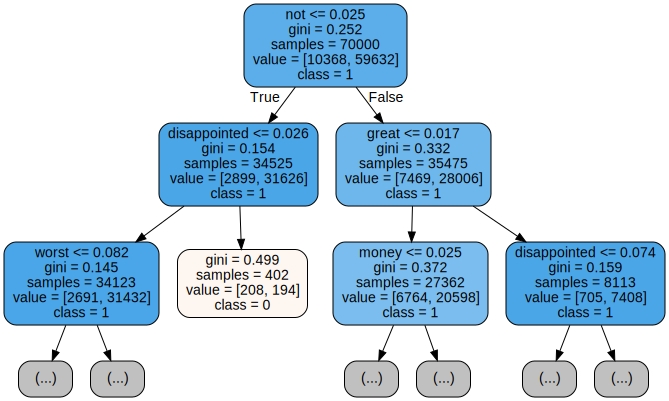

In [32]:
dot_data = tree.export_graphviz(tfidf_clf, out_file=None, 
                      feature_names=tfidf_vect.get_feature_names(),
                      max_depth= 2,         
                      class_names = class_name,  
                      filled=True, rounded=True,  
                      special_characters=False)  
graph = graphviz.Source(dot_data)  
graph

## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

In [33]:
# Please write all the code with proper documentation

100%|████████████████████████████████████████████| 6/6 [07:51<00:00, 87.93s/it]


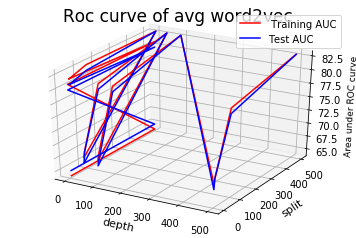

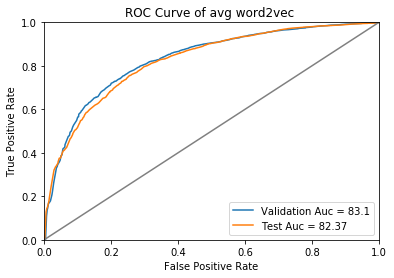

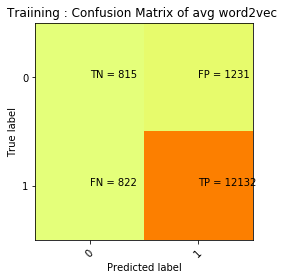

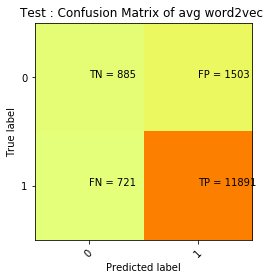

In [34]:
def avg_w2v(preprocessed_reviews, x, w2v_model):
    i=0
    list_of_sentance=[]
    for sentance in preprocessed_reviews:
        list_of_sentance.append(sentance.split())
                            
    is_your_ram_gt_16g=False
    want_to_use_google_w2v = False
    want_to_train_w2v = True
    if 1 == x:
        if want_to_train_w2v:
            # min_count = 5 considers only words that occured atleast 5 times
            w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
        elif want_to_use_google_w2v and is_your_ram_gt_16g:
            if os.path.isfile('GoogleNews-vectors-negative300.bin'):
                w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
                print(w2v_model.wv.most_similar('great'))
                print(w2v_model.wv.most_similar('worst'))
        else:
            print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

    w2v_words = list(w2v_model.wv.vocab)                      

    # average Word2Vec
    # compute average word2vec for each review.
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentance): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec) 
    
    return sent_vectors, list_of_sentance, w2v_model                          


#vectorizing using above function
avg_w2v_x_train, los_train, w2v_model = avg_w2v(x_train, 1, None)
avg_w2v_x_cv, los_cv, w2v_model = avg_w2v(x_cv, 0, w2v_model)
avg_w2v_x_test, los_test, w2v_model = avg_w2v(x_test, 0, w2v_model)


auc_cv = []
auc_test = []
depth = [1, 5, 10, 50, 100, 500]
split = [5, 10, 100, 500]
depth_x = []
split_y = []
for i in tqdm(depth):
    for j in split:
        avg_w2v_clf = DecisionTreeClassifier(max_depth = i , min_samples_split = j )
        

        # fitting the model on crossvalidation train
        avg_w2v_clf.fit(avg_w2v_x_train, y_train)

    
        y_pred_proba = avg_w2v_clf.predict_proba(avg_w2v_x_cv)[::,1]
        fpr, tpr, _ = metrics.roc_curve(y_cv,  y_pred_proba)
        auc_cv.append(np.round(metrics.roc_auc_score(y_cv, y_pred_proba)*100))
    
        y_pred_proba1 = avg_w2v_clf.predict_proba(avg_w2v_x_test)[::,1]
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba1)
        auc_test.append(np.round(metrics.roc_auc_score(y_test, y_pred_proba1)*100))
    
        depth_x.append(i)
        split_y.append(j)
        

from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})

ax.set_xlabel("depth", fontsize=11)
ax.set_ylabel("split", fontsize=11)
ax.set_zlabel("Area under ROC curve   ", fontsize = 9, rotation=150)
ax.set_title("Roc curve of avg word2vec", fontsize=17)

ax.plot(depth_x, split_y, auc_cv, color='red', label =" Training AUC")
ax.plot(depth_x, split_y, auc_test, color='blue', label = "Test AUC")    
ax.legend()
plt.show()        
        
    
index  = auc_cv.index(max(auc_cv))
i = index//4
j = index % 4
aw_opt_depth = depth[i]
aw_opt_split = split[j]






avg_w2v_clf = DecisionTreeClassifier(max_depth = aw_opt_depth , min_samples_split = aw_opt_split )
avg_w2v_clf.fit(avg_w2v_x_train, y_train)





#auc curve of optimal k on validation and test data
y_predk_proba = avg_w2v_clf.predict_proba(avg_w2v_x_cv)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_cv,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_cv, y_predk_proba)*100, 2)
aw_tr_auc = auc

plt.plot(fpr,tpr,label="Validation Auc = "+str(auc))
y_predk_proba = avg_w2v_clf.predict_proba(avg_w2v_x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_test, y_predk_proba)*100, 2)
aw_ts_auc = auc

plt.plot(fpr,tpr,label="Test Auc = "+str(auc))
plt.legend(loc=4)
plt.plot([x/10 for x in range(0, 11)],[x/10 for x in range(0, 11)], color='grey')
plt.title("ROC Curve of avg word2vec ")
plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()



y_pred_test = avg_w2v_clf.predict(avg_w2v_x_test)
y_pred_cv = avg_w2v_clf.predict(avg_w2v_x_cv)



# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_cv,y_pred_cv)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title("Traiining : Confusion Matrix of avg word2vec ")
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()



# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_test,y_pred_test)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title("Test : Confusion Matrix of avg word2vec ")
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

In [35]:
# Please write all the code with proper documentation

100%|████████████████████████████████████████████| 6/6 [07:00<00:00, 77.62s/it]


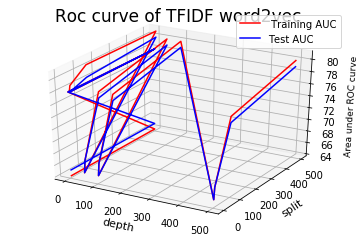

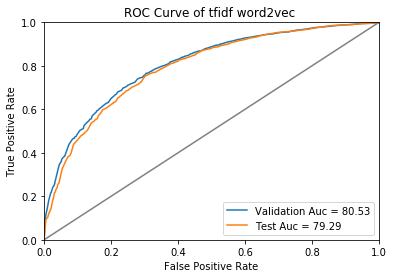

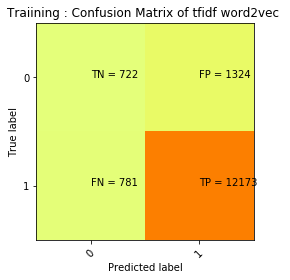

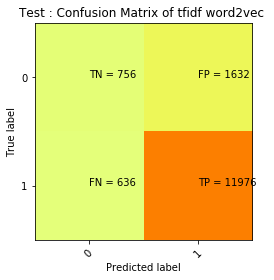

In [36]:
def tfidf_w2v(preprocessed_reviews, list_of_sentance, w2v_model, w2v_words, x, model):
    if 1 == x:
        model = TfidfVectorizer()
        tf_idf_matrix = model.fit_transform(preprocessed_reviews)
        # we are converting a dictionary with word as a key, and the idf as a value
        dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
        # TF-IDF weighted Word2Vec
        tfidf_feat = model.get_feature_names() # tfidf words/col-names
        # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
    else: 
        tf_idf_matrix = model.transform(preprocessed_reviews)
        dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
        tfidf_feat = model.get_feature_names()
        
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sentance): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are  
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors, model               


#vectorizing using above function
tfidf_w2v_x_train, model = tfidf_w2v(x_train, los_train, w2v_model, list(w2v_model.wv.vocab), 1, None)
tfidf_w2v_x_cv, model = tfidf_w2v(x_cv, los_cv, w2v_model, list(w2v_model.wv.vocab), 0, model)
tfidf_w2v_x_test, model = tfidf_w2v(x_test, los_test, w2v_model, list(w2v_model.wv.vocab), 0, model)



auc_cv = []
auc_test = []
depth = [1, 5, 10, 50, 100, 500]
split = [5, 10, 100, 500]
depth_x = []
split_y = []
for i in tqdm(depth):
    for j in split:
        tfidf_w2v_clf = DecisionTreeClassifier(max_depth = i , min_samples_split = j )
        

        # fitting the model on crossvalidation train
        tfidf_w2v_clf.fit(tfidf_w2v_x_train, y_train)

    
        y_pred_proba = tfidf_w2v_clf.predict_proba(tfidf_w2v_x_cv)[::,1]
        fpr, tpr, _ = metrics.roc_curve(y_cv,  y_pred_proba)
        auc_cv.append(np.round(metrics.roc_auc_score(y_cv, y_pred_proba)*100))
    
        y_pred_proba1 = tfidf_w2v_clf.predict_proba(tfidf_w2v_x_test)[::,1]
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba1)
        auc_test.append(np.round(metrics.roc_auc_score(y_test, y_pred_proba1)*100))
    
        depth_x.append(i)
        split_y.append(j)
        

from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})

ax.set_xlabel("depth", fontsize=11)
ax.set_ylabel("split", fontsize=11)
ax.set_zlabel("Area under ROC curve   ", fontsize = 9, rotation=150)
ax.set_title("Roc curve of TFIDF word2vec", fontsize=17)

ax.plot(depth_x, split_y, auc_cv, color='red', label =" Training AUC")
ax.plot(depth_x, split_y, auc_test, color='blue', label = "Test AUC")    
ax.legend(loc='best')
plt.show()        
        
        
    
index  = auc_cv.index(max(auc_cv))
i = index//4
j = index % 4
tw_opt_depth = depth[i]
tw_opt_split = split[j]






tfidf_w2v_clf = DecisionTreeClassifier(max_depth = tw_opt_depth , min_samples_split = tw_opt_split )
tfidf_w2v_clf.fit(tfidf_w2v_x_train, y_train)




#auc curve of optimal k on validation and test data
y_predk_proba = tfidf_w2v_clf.predict_proba(tfidf_w2v_x_cv)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_cv,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_cv, y_predk_proba)*100, 2)
tw_tr_auc = auc

plt.plot(fpr,tpr,label="Validation Auc = "+str(auc))
y_predk_proba = tfidf_w2v_clf.predict_proba(tfidf_w2v_x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_test, y_predk_proba)*100, 2)
tw_ts_auc = auc

plt.plot(fpr,tpr,label="Test Auc = "+str(auc))
plt.legend(loc=4)
plt.plot([x/10 for x in range(0, 11)],[x/10 for x in range(0, 11)], color='grey')
plt.title("ROC Curve of tfidf word2vec ")
plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()



y_pred_test = tfidf_w2v_clf.predict(tfidf_w2v_x_test)
y_pred_cv = tfidf_w2v_clf.predict(tfidf_w2v_x_cv)



# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_cv,y_pred_cv)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title("Traiining : Confusion Matrix of tfidf word2vec ")
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()



# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_test,y_pred_test)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title("Test : Confusion Matrix of tfidf word2vec ")
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

# [6] Conclusions

In [37]:
# Please compare all your models using Prettytable library

In [38]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model Technique", "Max Depth", "Min Samples Split", "Training Auc", "Test Auc"]

x.add_row(["Bag of words",b_opt_depth , b_opt_split, b_tr_auc, b_ts_auc ])
x.add_row(["Tfidf", t_opt_depth, t_opt_split, t_tr_auc, t_ts_auc])
x.add_row(["Avg Word2vec", aw_opt_depth, aw_opt_split, aw_tr_auc, aw_ts_auc])
x.add_row(["Tfidf Word2vec", tw_opt_depth, tw_opt_split, tw_tr_auc, tw_ts_auc])

print(x)

+-----------------+-----------+-------------------+--------------+----------+
| Model Technique | Max Depth | Min Samples Split | Training Auc | Test Auc |
+-----------------+-----------+-------------------+--------------+----------+
|   Bag of words  |     50    |        500        |    83.48     |  83.87   |
|      Tfidf      |     50    |        500        |    82.53     |  82.82   |
|   Avg Word2vec  |     10    |        100        |     83.1     |  82.37   |
|  Tfidf Word2vec |     10    |        100        |    80.53     |  79.29   |
+-----------------+-----------+-------------------+--------------+----------+


# Step for all code:

In [ ]:
Preprocessing:
    1. imported all needed library like 
       KNN for algo that is going to be used
       BeautifulSoup for parsing HTML and XML
       Tfidfvectorizer for tfidf
       CountVectorizer for bag of words
       Gensim for word2vec
       ROC curve for Auc 
       Confuscion Matrix for Confusion Matrix and so on..
    2. Loading data using SQL 
    3. Seting Score feature > 3 as 1 and < 3 as 0
    4. Sorting the dataframe based on productid
    5. Removing all html, punctuation, making upper to lower case etc.
    6. Making dataset balance from imbalanced
    7. Removing duplicates
    8. Taking 70000 dataset for traing and 15000 for CV and Test each
    
BOW and tfidf and average word2vec and tfidf word2vec :

    1. Fitting Training data into classifier
    
    2. Transforming data of Training and CV and Testing
    3. Running the model with different depth and split to get best auc
    4. Printing Auc of Train and Test to visualize how different value of
       depth and split is giving different Auc.
    5. Fitting optimal depth and split to classifier
    6. finding predicted value of Test and CV
    7. Ploting Roc curve of predicted value to get accuracy of optimal dpeth and
       split or model
    8. Showing confusion matrix of Cv and Test 